In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from PIL import Image

from keras.models import Sequential
from keras import losses,optimizers
from keras.layers import Dense, Flatten, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)



In [4]:
# Load the dataset to be used for classification
!unzip dataset.zip


Archive:  dataset.zip
   creating: training/Apple/
  inflating: training/Apple/00001.jpg  
  inflating: training/Apple/00003.jpg  
  inflating: training/Apple/00004.jpg  
  inflating: training/Apple/00005.jpg  
  inflating: training/Apple/00006.jpg  
  inflating: training/Apple/00007.jpg  
  inflating: training/Apple/00008.jpg  
  inflating: training/Apple/00009.jpg  
  inflating: training/Apple/00011.jpg  
  inflating: training/Apple/00012.jpg  
  inflating: training/Apple/00013.jpg  
  inflating: training/Apple/00014.jpg  
  inflating: training/Apple/00015.jpg  
  inflating: training/Apple/00016.jpg  
  inflating: training/Apple/00017.jpg  
  inflating: training/Apple/00018.jpg  
  inflating: training/Apple/00020.jpg  
  inflating: training/Apple/00022.jpg  
  inflating: training/Apple/00023.jpg  
  inflating: training/Apple/00024.jpg  
  inflating: training/Apple/00025.jpg  
  inflating: training/Apple/00026.jpg  
  inflating: training/Apple/00027.jpg  
  inflating: training/Apple/0

In [ ]:
### Splitting into training and validation set
# Fisrtly, we split the 20% of the entire dataset, then we choose the final model and we fit it with only 1% of validation set 

import cv2
import glob
import os
import shutil

folderName = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

if not os.path.exists('./validation'):
    os.mkdir('./validation')

for s in folderName:
    if not os.path.exists('./validation/'+s):
        os.mkdir('./validation/'+s)


    imgs = os.listdir('./training/'+s)

    for i in range(int(0.01*len(imgs))):
        shutil.move('./training/' +s+ '/'+imgs[i], './validation/'+s)


In [ ]:
# Dataset folders 
dataset_dir = 'training'
dataset_validation_dir = 'validation'

In [ ]:
# Labels of our dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']


In [ ]:
### MODELS METADATA
input_shape = (256, 256, 3)
epochs = 50
batch_size = 32

In [ ]:
# We perform Data Augmentation only on the training set, useful for few data in dataset or to avoid overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image
val_data_gen = ImageDataGenerator(rescale=1/255)

train_generator = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

validation_generator = val_data_gen.flow_from_directory(directory=dataset_validation_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       seed=seed)

Found 17559 images belonging to 14 classes.
Found 169 images belonging to 14 classes.


In [ ]:
# Now we import some new metrics, because of our unbalanced dataset the most important metric is F1 Score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
auc = tf.keras.metrics.AUC()

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Final Model:

# First we perform a Resizing with a lower resolution of our images
# Then we permorm a (Conv + LeakyReLU + MaxPool) x 5 + GAP + FC x 2

def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    resize1_layer = tfkl.Resizing(128, 128, interpolation="bicubic", name ='Resize1')(input_layer) # bicubic or nearest or bilinear

    conv1 = tfkl.Conv2D(
        name='Hidden1',
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed=seed)
        #kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(resize1_layer)
    act1 = LeakyReLU()(conv1)  # is compute after the weighted sum and before the pooling
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(act1)


    conv2 = tfkl.Conv2D(
        name='Hidden2',
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed=seed)
        #kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pool1)
    act2 = LeakyReLU()(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(act2)


    conv3 = tfkl.Conv2D(
        name='Hidden3',
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed=seed)
        #kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pool2)
    act3 = LeakyReLU()(conv3)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(act3)

    conv4 = tfkl.Conv2D(
        name='Hidden4',
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed = seed)
        #kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pool3)
    act4 = LeakyReLU()(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(act4)

    conv5 = tfkl.Conv2D(
        name='Hidden5',
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed=seed)
        #kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pool4)
    act5 = LeakyReLU()(conv5)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(act5)
    
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(pool5)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GlobalPoolingDropout')(glob_pooling)
    # global pooling will perform the spatial average of our feature maps

    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), activation='relu')(glob_pooling)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), name='Output')(classifier_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(),  metrics=['accuracy', auc, f1_m]) # the most important is F1 Score

    return model

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)  # save best only va messo false perchè abbiamo già early stopping

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------        ### In Early Stopping we look at F1 Score on the validation
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', mode = 'max', patience=10, restore_best_weights=True) 
  callbacks.append(es_callback)

  return callbacks

DATA AUGGG

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.6 MB/s 


In [ ]:
# Build model (for data augmentation training)
model = build_model(input_shape)
model.summary()

import visualkeras
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 Resize1 (Resizing)          (None, 128, 128, 3)       0         
                                                                 
 Hidden1 (Conv2D)            (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 Hidden2 (Conv2D)            (None, 64, 64, 32)        4640      
                                                             

'\nimport visualkeras\nvisualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)\n'

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [ ]:
# tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
# tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = train_generator,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = validation_generator,
    callbacks = aug_callbacks
).history

Epoch 1/50
549/549 [==============================] - ETA: 0s - loss: 1.7957 - accuracy: 0.4408 - auc: 0.8544 - f1_m: 0.3333

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 301s 530ms/step - loss: 1.7957 - accuracy: 0.4408 - auc: 0.8544 - f1_m: 0.3333 - val_loss: 1.3399 - val_accuracy: 0.5621 - val_auc: 0.9259 - val_f1_m: 0.5436
Epoch 2/50
549/549 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.6043 - auc: 0.9372 - f1_m: 0.5754

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 1.2254 - accuracy: 0.6043 - auc: 0.9372 - f1_m: 0.5754 - val_loss: 0.7343 - val_accuracy: 0.7751 - val_auc: 0.9789 - val_f1_m: 0.7403
Epoch 3/50
549/549 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.7093 - auc: 0.9675 - f1_m: 0.6977

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 292s 531ms/step - loss: 0.8778 - accuracy: 0.7093 - auc: 0.9675 - f1_m: 0.6977 - val_loss: 0.5038 - val_accuracy: 0.8343 - val_auc: 0.9898 - val_f1_m: 0.8306
Epoch 4/50
549/549 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.7860 - auc: 0.9806 - f1_m: 0.7810

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 301s 548ms/step - loss: 0.6528 - accuracy: 0.7860 - auc: 0.9806 - f1_m: 0.7810 - val_loss: 0.3596 - val_accuracy: 0.8757 - val_auc: 0.9950 - val_f1_m: 0.8658
Epoch 5/50
549/549 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.8272 - auc: 0.9869 - f1_m: 0.8266

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 292s 531ms/step - loss: 0.5214 - accuracy: 0.8272 - auc: 0.9869 - f1_m: 0.8266 - val_loss: 0.3698 - val_accuracy: 0.8876 - val_auc: 0.9945 - val_f1_m: 0.8894
Epoch 6/50
549/549 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8583 - auc: 0.9903 - f1_m: 0.8591

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 305s 555ms/step - loss: 0.4335 - accuracy: 0.8583 - auc: 0.9903 - f1_m: 0.8591 - val_loss: 0.3772 - val_accuracy: 0.8639 - val_auc: 0.9922 - val_f1_m: 0.8503
Epoch 7/50
549/549 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8724 - auc: 0.9912 - f1_m: 0.8730

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 315s 574ms/step - loss: 0.3933 - accuracy: 0.8724 - auc: 0.9912 - f1_m: 0.8730 - val_loss: 0.1642 - val_accuracy: 0.9290 - val_auc: 0.9990 - val_f1_m: 0.9492
Epoch 8/50
549/549 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8867 - auc: 0.9929 - f1_m: 0.8863

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 324s 591ms/step - loss: 0.3494 - accuracy: 0.8867 - auc: 0.9929 - f1_m: 0.8863 - val_loss: 0.1723 - val_accuracy: 0.9527 - val_auc: 0.9987 - val_f1_m: 0.9341
Epoch 9/50
549/549 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8984 - auc: 0.9942 - f1_m: 0.8990

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 326s 594ms/step - loss: 0.3102 - accuracy: 0.8984 - auc: 0.9942 - f1_m: 0.8990 - val_loss: 0.1168 - val_accuracy: 0.9349 - val_auc: 0.9995 - val_f1_m: 0.9338
Epoch 10/50
549/549 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.9107 - auc: 0.9951 - f1_m: 0.9114

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 323s 589ms/step - loss: 0.2742 - accuracy: 0.9107 - auc: 0.9951 - f1_m: 0.9114 - val_loss: 0.1463 - val_accuracy: 0.9408 - val_auc: 0.9991 - val_f1_m: 0.9291
Epoch 11/50
549/549 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.9133 - auc: 0.9944 - f1_m: 0.9132

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 313s 570ms/step - loss: 0.2730 - accuracy: 0.9133 - auc: 0.9944 - f1_m: 0.9132 - val_loss: 0.1611 - val_accuracy: 0.9408 - val_auc: 0.9990 - val_f1_m: 0.9396
Epoch 12/50
549/549 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9171 - auc: 0.9951 - f1_m: 0.9173

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 294s 536ms/step - loss: 0.2569 - accuracy: 0.9171 - auc: 0.9951 - f1_m: 0.9173 - val_loss: 0.1105 - val_accuracy: 0.9645 - val_auc: 0.9995 - val_f1_m: 0.9500
Epoch 13/50
549/549 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9230 - auc: 0.9950 - f1_m: 0.9249

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 289s 526ms/step - loss: 0.2410 - accuracy: 0.9230 - auc: 0.9950 - f1_m: 0.9249 - val_loss: 0.1316 - val_accuracy: 0.9408 - val_auc: 0.9993 - val_f1_m: 0.9312
Epoch 14/50
549/549 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9292 - auc: 0.9961 - f1_m: 0.9304

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 291s 529ms/step - loss: 0.2217 - accuracy: 0.9292 - auc: 0.9961 - f1_m: 0.9304 - val_loss: 0.2459 - val_accuracy: 0.8935 - val_auc: 0.9977 - val_f1_m: 0.8847
Epoch 15/50
549/549 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9278 - auc: 0.9960 - f1_m: 0.9275

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 291s 530ms/step - loss: 0.2204 - accuracy: 0.9278 - auc: 0.9960 - f1_m: 0.9275 - val_loss: 0.1483 - val_accuracy: 0.9408 - val_auc: 0.9992 - val_f1_m: 0.9318
Epoch 16/50
549/549 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9342 - auc: 0.9960 - f1_m: 0.9343

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 294s 536ms/step - loss: 0.2050 - accuracy: 0.9342 - auc: 0.9960 - f1_m: 0.9343 - val_loss: 0.2301 - val_accuracy: 0.9172 - val_auc: 0.9984 - val_f1_m: 0.9130
Epoch 17/50
549/549 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9380 - auc: 0.9963 - f1_m: 0.9393

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 0.1948 - accuracy: 0.9380 - auc: 0.9963 - f1_m: 0.9393 - val_loss: 0.0528 - val_accuracy: 0.9763 - val_auc: 0.9999 - val_f1_m: 0.9762
Epoch 18/50
549/549 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9371 - auc: 0.9964 - f1_m: 0.9373

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 0.1964 - accuracy: 0.9371 - auc: 0.9964 - f1_m: 0.9373 - val_loss: 0.1106 - val_accuracy: 0.9704 - val_auc: 0.9964 - val_f1_m: 0.9790
Epoch 19/50
549/549 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9416 - auc: 0.9965 - f1_m: 0.9427

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 297s 540ms/step - loss: 0.1877 - accuracy: 0.9416 - auc: 0.9965 - f1_m: 0.9427 - val_loss: 0.1038 - val_accuracy: 0.9704 - val_auc: 0.9967 - val_f1_m: 0.9522
Epoch 20/50
549/549 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9417 - auc: 0.9966 - f1_m: 0.9415

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 0.1881 - accuracy: 0.9417 - auc: 0.9966 - f1_m: 0.9415 - val_loss: 0.0486 - val_accuracy: 0.9763 - val_auc: 0.9999 - val_f1_m: 0.9817
Epoch 21/50
549/549 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9443 - auc: 0.9967 - f1_m: 0.9451

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 290s 528ms/step - loss: 0.1768 - accuracy: 0.9443 - auc: 0.9967 - f1_m: 0.9451 - val_loss: 0.0592 - val_accuracy: 0.9822 - val_auc: 0.9999 - val_f1_m: 0.9816
Epoch 22/50
549/549 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9429 - auc: 0.9971 - f1_m: 0.9435

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 301s 548ms/step - loss: 0.1751 - accuracy: 0.9429 - auc: 0.9971 - f1_m: 0.9435 - val_loss: 0.0758 - val_accuracy: 0.9704 - val_auc: 0.9998 - val_f1_m: 0.9666
Epoch 23/50
549/549 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9439 - auc: 0.9967 - f1_m: 0.9443

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 296s 538ms/step - loss: 0.1755 - accuracy: 0.9439 - auc: 0.9967 - f1_m: 0.9443 - val_loss: 0.0868 - val_accuracy: 0.9527 - val_auc: 0.9997 - val_f1_m: 0.9499
Epoch 24/50
549/549 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9428 - auc: 0.9964 - f1_m: 0.9427

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 297s 541ms/step - loss: 0.1808 - accuracy: 0.9428 - auc: 0.9964 - f1_m: 0.9427 - val_loss: 0.0843 - val_accuracy: 0.9645 - val_auc: 0.9997 - val_f1_m: 0.9550
Epoch 25/50
549/549 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9507 - auc: 0.9977 - f1_m: 0.9507

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 0.1542 - accuracy: 0.9507 - auc: 0.9977 - f1_m: 0.9507 - val_loss: 0.0909 - val_accuracy: 0.9704 - val_auc: 0.9997 - val_f1_m: 0.9605
Epoch 26/50
549/549 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9497 - auc: 0.9972 - f1_m: 0.9499

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 288s 524ms/step - loss: 0.1611 - accuracy: 0.9497 - auc: 0.9972 - f1_m: 0.9499 - val_loss: 0.0259 - val_accuracy: 0.9941 - val_auc: 1.0000 - val_f1_m: 0.9921
Epoch 27/50
549/549 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9516 - auc: 0.9972 - f1_m: 0.9517

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 284s 517ms/step - loss: 0.1529 - accuracy: 0.9516 - auc: 0.9972 - f1_m: 0.9517 - val_loss: 0.0908 - val_accuracy: 0.9704 - val_auc: 0.9996 - val_f1_m: 0.9606
Epoch 28/50
549/549 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9488 - auc: 0.9970 - f1_m: 0.9500

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 286s 520ms/step - loss: 0.1588 - accuracy: 0.9488 - auc: 0.9970 - f1_m: 0.9500 - val_loss: 0.0717 - val_accuracy: 0.9704 - val_auc: 0.9998 - val_f1_m: 0.9789
Epoch 29/50
549/549 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9520 - auc: 0.9973 - f1_m: 0.9529

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 286s 521ms/step - loss: 0.1515 - accuracy: 0.9520 - auc: 0.9973 - f1_m: 0.9529 - val_loss: 0.0352 - val_accuracy: 0.9941 - val_auc: 1.0000 - val_f1_m: 0.9921
Epoch 30/50
549/549 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9554 - auc: 0.9978 - f1_m: 0.9555

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 284s 517ms/step - loss: 0.1380 - accuracy: 0.9554 - auc: 0.9978 - f1_m: 0.9555 - val_loss: 0.0680 - val_accuracy: 0.9586 - val_auc: 0.9998 - val_f1_m: 0.9635
Epoch 31/50
549/549 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9539 - auc: 0.9973 - f1_m: 0.9541

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 289s 526ms/step - loss: 0.1475 - accuracy: 0.9539 - auc: 0.9973 - f1_m: 0.9541 - val_loss: 0.0485 - val_accuracy: 0.9882 - val_auc: 0.9998 - val_f1_m: 0.9921
Epoch 32/50
549/549 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9545 - auc: 0.9968 - f1_m: 0.9549

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 287s 522ms/step - loss: 0.1551 - accuracy: 0.9545 - auc: 0.9968 - f1_m: 0.9549 - val_loss: 0.0527 - val_accuracy: 0.9882 - val_auc: 0.9999 - val_f1_m: 0.9868
Epoch 33/50
549/549 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9549 - auc: 0.9979 - f1_m: 0.9553

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 293s 534ms/step - loss: 0.1376 - accuracy: 0.9549 - auc: 0.9979 - f1_m: 0.9553 - val_loss: 0.0570 - val_accuracy: 0.9763 - val_auc: 0.9999 - val_f1_m: 0.9792
Epoch 34/50
549/549 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9581 - auc: 0.9977 - f1_m: 0.9590

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 288s 524ms/step - loss: 0.1339 - accuracy: 0.9581 - auc: 0.9977 - f1_m: 0.9590 - val_loss: 0.0437 - val_accuracy: 0.9882 - val_auc: 0.9999 - val_f1_m: 0.9763
Epoch 35/50
549/549 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9591 - auc: 0.9977 - f1_m: 0.9593

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 300s 546ms/step - loss: 0.1307 - accuracy: 0.9591 - auc: 0.9977 - f1_m: 0.9593 - val_loss: 0.0326 - val_accuracy: 0.9882 - val_auc: 1.0000 - val_f1_m: 0.9921
Epoch 36/50
549/549 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9583 - auc: 0.9969 - f1_m: 0.9580

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov28_13-08-42/ckpts/cp.ckpt/assets


549/549 [==============================] - 296s 539ms/step - loss: 0.1450 - accuracy: 0.9583 - auc: 0.9969 - f1_m: 0.9580 - val_loss: 0.0402 - val_accuracy: 0.9822 - val_auc: 0.9999 - val_f1_m: 0.9869


In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Best/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Best/assets


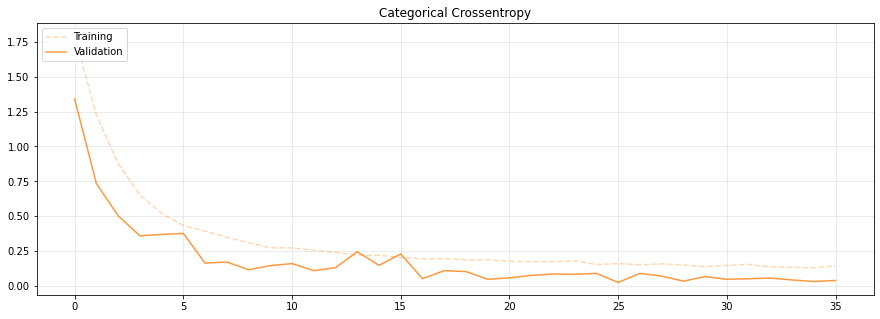

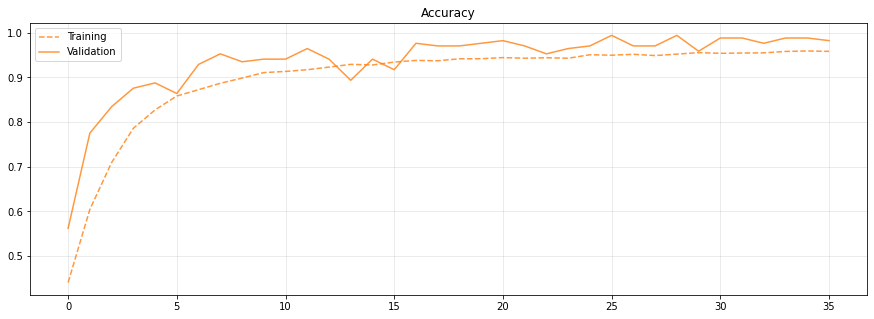

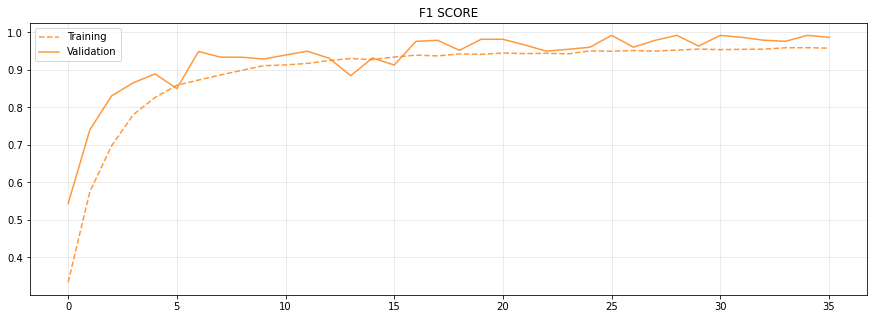

In [ ]:
# Plot the metrics in which we can detect the F1 Score between Training and Validation
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['f1_m'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_m'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('F1 SCORE')
plt.grid(alpha=.3)



plt.show()

TRANSFER LEARNING

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# RESNET50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_train_data_gen_TL = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        preprocessing_function=preprocess_input,  
                                        fill_mode='reflect',
                                        ) 
val_data_gen_TL = ImageDataGenerator(preprocessing_function=preprocess_input  
                                    )

train_generator_TL = aug_train_data_gen_TL.flow_from_directory(directory=dataset_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

validation_generator_TL = val_data_gen_TL.flow_from_directory(directory=dataset_validation_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       seed=seed)



In [ ]:
supernet = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3) 
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
# Use the supernet as feature extractor \\\ we do transfer learning
supernet.trainable = False  # the optimizer doesn't cosider the parameters of resnet during ottimization

inputs = tfk.Input(shape=(256,256,3))
x = tfkl.Resizing(128, 128, interpolation="bicubic")(inputs) 
x = supernet(x) # then we call the vgg model
x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
x = tfkl.Dropout(0.3, seed=seed, name='GlobalPoolingDropout')(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x) ### there we put the L2 regularizers
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model_tl')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', auc, f1_m])
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = train_generator_TL,
    batch_size = 32,
    epochs = 20,
    validation_data = validation_generator_TL,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning ResNet50', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning ResNet50', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['f1_m'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_m'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['f1_m'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_f1_m'], label='Transfer Learning ResNet50', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('F1 Score')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('TransferLearningModelResNet') ###
del tl_model  # To avoid filling the memory

FINE TUNING

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModelResNet', custom_objects={'f1_m':f1_m})
ft_model.summary()

In [ ]:
# Set all RESNET50 layers to True
ft_model.get_layer('resnet50').trainable = True 
for i, layer in enumerate(ft_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first 143 layers, e.g., until 143th because we want to freeze only 4 conv block layers and keep trainable the last conv block layer  
for i, layer in enumerate(ft_model.get_layer('resnet50').layers[:143]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', auc, f1_m])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = train_generator_TL,
    batch_size = 32,
    epochs = 20,
    validation_data = validation_generator_TL,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
ft_model.save('FineTuningModelResnet')
del ft_model

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['f1_m'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_m'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['f1_m'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_f1_m'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['f1_m'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_f1_m'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('F1 Score')
plt.grid(alpha=.3)

plt.show()